In [ ]:
%%shell
pip install unidecode

In [ ]:
import re
import json
import spacy
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from unidecode import unidecode
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from spacy.tokens.doc import Doc
from numpy.typing import ArrayLike
from typing import List
from tqdm import tqdm

plt.style.use("ggplot")
tqdm.pandas()

In [ ]:
spacy.cli.download("es_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
nlp = spacy.load("es_core_news_sm")

In [ ]:
with open("games.html", encoding="latin1") as f:
    data = f.read()
soup = BeautifulSoup(data)
soup

In [ ]:
text = soup.get_text()

In [ ]:
text

In [ ]:
sp_pat = re.compile(r"[^a-z ]")
spaces_pat = re.compile(r"\s+")
def preprocess(text: str) -> str:
    norm_text = unidecode(text)
    lower_text = norm_text.lower()
    sp_text = re.sub(sp_pat, " ", lower_text)
    spaces_text = re.sub(spaces_pat, " ", sp_text)
    return spaces_text.strip()

In [ ]:
preprocess_text = preprocess(text)

In [ ]:
pprint(preprocess_text)

In [ ]:
doc = nlp(preprocess_text)

In [ ]:
vects = list(map(lambda token: token.vector.reshape(1, -1), doc))

In [ ]:
features = np.concatenate(vects, axis=0)

In [ ]:
features.shape

In [ ]:
model = KMeans(n_clusters=10).fit(features)

In [ ]:
assigns = model.predict(features)

In [ ]:
assigns.shape

In [ ]:
assigns[:10]

In [ ]:
centroids = model.cluster_centers_
centroids.shape

In [ ]:
dists = euclidean_distances(features, centroids)
dists.shape

In [ ]:
def get_closest_words(
    doc: Doc,
    dists: ArrayLike,
    cluster_id: int,
    top_n: int
    ) -> List[str]:
    dists_cluster = dists[:, cluster_id]
    ranking = sorted(zip(doc, dists_cluster), key=lambda x: x[1])
    sorted_words = map(lambda x: x[0], ranking)
    top = [next(sorted_words) for _ in range(top_n)]
    return top

In [ ]:
get_closest_words(doc, dists, 6, 40)

In [ ]:
k_range = np.arange(100, 1001, 100)
k_range

In [ ]:
model.inertia_

In [ ]:
scores = [
    KMeans(n_clusters=k).fit(features).inertia_
    for k in k_range
    ]

In [ ]:
fig, ax = plt.subplots()
ax.plot(k_range, scores)
ax.set(xlabel="N clusters", ylabel="Inertia")

# Document clustering

https://www.kaggle.com/datasets/rmisra/news-category-dataset/

In [ ]:
%%shell
cp '/content/drive/MyDrive/archive.zip' .
unzip archive.zip

Archive:  archive.zip
replace News_Category_Dataset_v3.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: News_Category_Dataset_v3.json  


In [ ]:
%%shell
apt install jq

In [ ]:
%%shell
cat "News_Category_Dataset_v3.json" | head -n 10 | jq

{
  "link": "https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9",
  "headline": "Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters",
  "category": "U.S. NEWS",
  "short_description": "Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.",
  "authors": "Carla K. Johnson, AP",
  "date": "2022-09-23"
}
{
  "link": "https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe",
  "headline": "American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",
  "category": "U.S. NEWS",
  "short_description": "He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",
  "authors": "Mary Papenfuss",
  "date": "2022-09-23"
}
{
  "link": 

In [ ]:
with open("News_Category_Dataset_v3.json", "r") as f:
    lines = f.read().split("\n")
    valid_data = []
    for line in lines:
        try:
            valid_data.append(json.loads(line))
        except:
            print("Invalid json")
    df = pd.DataFrame(valid_data).filter(["short_description", "category"])

Invalid json


In [ ]:
df

,short_description,category
0,Health experts said it is too early to predict...,U.S. NEWS
1,He was subdued by passengers and crew when he ...,U.S. NEWS
2,"""Until you have a dog you don't understand wha...",COMEDY
3,"""Accidentally put grown-up toothpaste on my to...",PARENTING
4,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS
...,...,...
209522,Verizon Wireless and AT&T are already promotin...,TECH
209523,"Afterward, Azarenka, more effusive with the pr...",SPORTS
209524,"Leading up to Super Bowl XLVI, the most talked...",SPORTS
209525,CORRECTION: An earlier version of this story i...,SPORTS


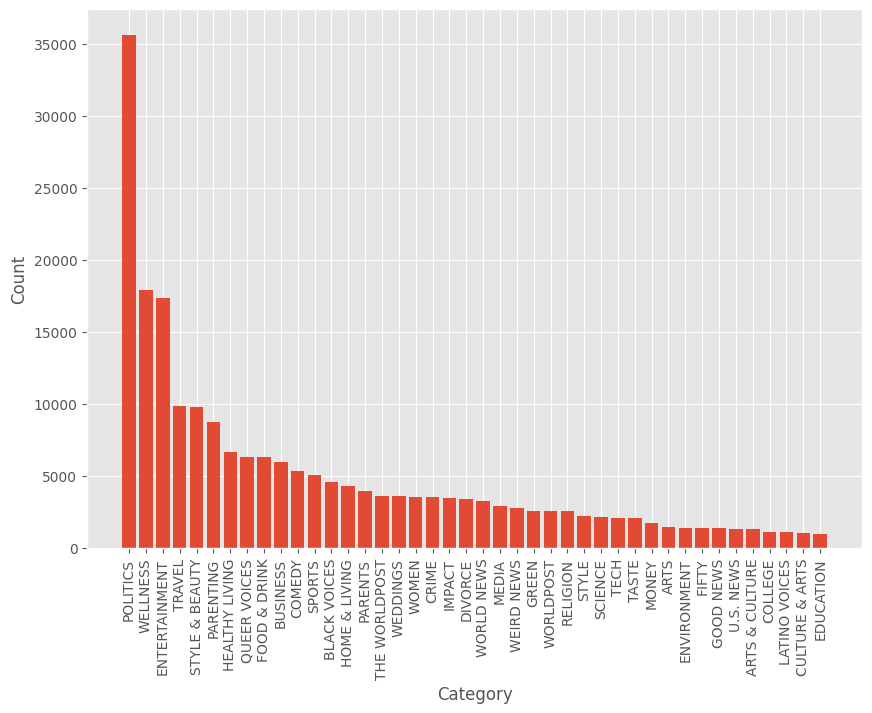

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
counts = df.category.value_counts()
ax.bar(counts.index, counts)
ax.set(xlabel="Category", ylabel="Count")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
most_freq_cats = counts.index[:6].to_list()
most_freq_cats

['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY']

In [ ]:
filtered_df = df.query("category in @most_freq_cats")
filtered_df.shape

(90623, 2)

In [ ]:
df_sample = (
    filtered_df
    .groupby("category")
    .sample(2000, replace=False)
)

In [ ]:
df_sample

,short_description,category
110942,,ENTERTAINMENT
15465,"The adult film star was reportedly paid $130,0...",ENTERTAINMENT
8002,The New Yorker's Saturday cartoon also feature...,ENTERTAINMENT
84381,Police are reportedly taking items out of his ...,ENTERTAINMENT
11047,Very angry indeed!,ENTERTAINMENT
...,...,...
153027,The eulogy is the foundational document of our...,WELLNESS
146792,"As he told me the story, he kept emphasizing h...",WELLNESS
195728,"Don't get me wrong, I admire elegance and have...",WELLNESS
201375,"""This is one of the greatest drug threats we h...",WELLNESS


In [ ]:
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"]
    )

In [ ]:
nlp.component_names

['tok2vec']

In [ ]:
def get_vector(text: str) -> ArrayLike:
    doc = nlp(text)
    return doc.vector.reshape(1, -1)

In [ ]:
df_vectors = df_sample.assign(
    vector=lambda df: df.short_description.progress_apply(get_vector)
    )

100%|██████████| 10000/10000 [00:42<00:00, 232.87it/s]


In [ ]:
final_df = (
    df_vectors
    .assign(vsize=df_vectors.vector.apply(lambda vector: vector.size))
    .query("vsize > 0")
    .drop(columns="vsize")
    )

In [ ]:
final_df

,short_description,category,vector
15465,"The adult film star was reportedly paid $130,0...",ENTERTAINMENT,"[[-0.1745636, -0.1663846, 0.3871856, -0.021522..."
8002,The New Yorker's Saturday cartoon also feature...,ENTERTAINMENT,"[[0.32841644, -0.42955488, -0.22754255, 0.1425..."
84381,Police are reportedly taking items out of his ...,ENTERTAINMENT,"[[0.100376315, 0.17277703, 0.02408136, 0.07460..."
11047,Very angry indeed!,ENTERTAINMENT,"[[0.5678638, -0.75137985, 0.43591934, -0.64967..."
59730,HEH?!,ENTERTAINMENT,"[[-0.5697575, -0.5566229, 0.16515397, -1.41609..."
...,...,...,...
153027,The eulogy is the foundational document of our...,WELLNESS,"[[0.08311751, -0.05572803, -0.024969941, 0.174..."
146792,"As he told me the story, he kept emphasizing h...",WELLNESS,"[[0.03330018, -0.20008293, 0.11495575, 0.01678..."
195728,"Don't get me wrong, I admire elegance and have...",WELLNESS,"[[0.019680439, -0.14422049, -0.07817514, 0.101..."
201375,"""This is one of the greatest drug threats we h...",WELLNESS,"[[-0.03980771, -0.3526388, -0.21192358, 0.2617..."


In [ ]:
features = np.concatenate(final_df.vector.to_list(), axis=0)
features.shape

(9467, 96)

In [ ]:
model = KMeans(n_clusters=10).fit(features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
assigns = model.predict(features)

In [ ]:
df_cluster = final_df.assign(assigns=assigns)
df_cluster

,short_description,category,vector,assigns
15465,"The adult film star was reportedly paid $130,0...",ENTERTAINMENT,"[[-0.1745636, -0.1663846, 0.3871856, -0.021522...",4
8002,The New Yorker's Saturday cartoon also feature...,ENTERTAINMENT,"[[0.32841644, -0.42955488, -0.22754255, 0.1425...",4
84381,Police are reportedly taking items out of his ...,ENTERTAINMENT,"[[0.100376315, 0.17277703, 0.02408136, 0.07460...",1
11047,Very angry indeed!,ENTERTAINMENT,"[[0.5678638, -0.75137985, 0.43591934, -0.64967...",9
59730,HEH?!,ENTERTAINMENT,"[[-0.5697575, -0.5566229, 0.16515397, -1.41609...",3
...,...,...,...,...
153027,The eulogy is the foundational document of our...,WELLNESS,"[[0.08311751, -0.05572803, -0.024969941, 0.174...",6
146792,"As he told me the story, he kept emphasizing h...",WELLNESS,"[[0.03330018, -0.20008293, 0.11495575, 0.01678...",6
195728,"Don't get me wrong, I admire elegance and have...",WELLNESS,"[[0.019680439, -0.14422049, -0.07817514, 0.101...",1
201375,"""This is one of the greatest drug threats we h...",WELLNESS,"[[-0.03980771, -0.3526388, -0.21192358, 0.2617...",7


In [ ]:
ct = (
    pd
    .crosstab(df_cluster.category, df_cluster.assigns)
)

In [ ]:
ct.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='assigns')

In [ ]:
ct

assigns,0,1,2,3,4,5,6,7,8,9
category,,,,,,,,,,
ENTERTAINMENT,10,164,280,92,321,167,164,213,128,190
POLITICS,5,297,196,24,466,166,238,199,141,99
STYLE & BEAUTY,161,297,41,8,272,328,474,280,64,72
TRAVEL,5,577,22,9,155,345,492,204,48,53
WELLNESS,2,488,30,0,105,214,980,117,43,21


<Axes: xlabel='assigns', ylabel='category'>

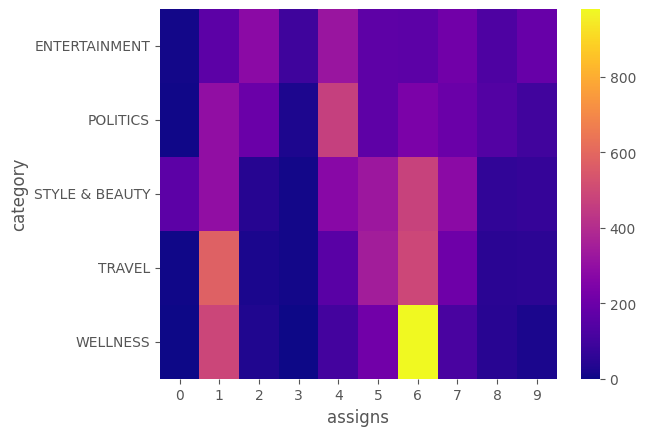

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(ct, cmap="plasma", ax=ax)

https://arxiv.org/pdf/2006.08177.pdf